# Advanced Lane Finding Project
---
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---

## Compute Camera Calibration and Correct Lens Distortion

Camera calibration is the process of undoing the light distortion by the camera lens that warps certain parts of the image.  The magnitude of distortion depends on the physical shape of the lens.  The following steps are involved in camera calibration.

1. A number of images need to be taken of a chessboard pattern by the camera which we want to calibrate.
    * The chessboard is essentially a grid of known corners where the chess spaces intersect.  These generated corners are known objective points on a grid that can be algorithmically generated for correlation with the corresponding corners detected from the camera images (called image points) to measure the distortion produced by the camera lens.  
    * The chessboard pattern and the camera images are provided for this project.
2. Generate the objective points on the chess board.
3. Detect the chessboard corners (image points) on the camera images.
4. Feed objective points and image points into the OpenCV cv2.calibrateCamera method to compute the camera calibration matrix and distortion coefficients.
5. Call cv2.undistort method with the camera calibration matrix and the distortion coefficients to undo the distortion effect of the camera lens on a test camera image to verify correctness.
6. Save the camera calibration matrix and the distortion coefficients to a pickle file for later use in correcting other images taken from the same camera.

The code cell below performs steps 1 through 3, above.  It also saves the images of the detected corners in _output_images/corners_ for later review.

In [19]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        corner_file = fname.replace('camera_cal/', 'output_images/corners/corners_')
        mpimg.imsave(corner_file, img)

Now that we have the objective points and the image points, we are ready to compute the camera calibration matrix and distortion parameters.  The code cell below performs steps 3 to 6, above, as well as plotting the last test camera image and its undistorted image for visual comparison.  The undistorted images can also be seen in the output_images folder.  As shown below, the most visible sign of removing the camera lens distortion is the straigtening of the curve lines near the edges of the image.

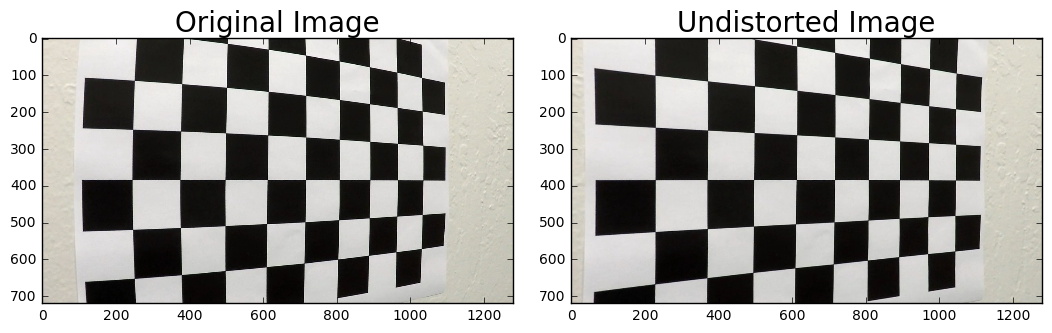

In [23]:
import pickle

# Do camera calibration given object points and image points
img_size = img.shape[0:2]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

# Undistort three test images and write them out to disk for review.
calibration_test_images = ['calibration2', 'calibration3', 'calibration5']
for test_name in calibration_test_images:
    img = mpimg.imread('camera_cal/' + test_name + '.jpg')
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('output_images/' + test_name + '_undistorted.jpg', dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open("camera_cal_pickle.p", "wb") )

# Plot the last distorted and undistorted test images for visual comparison
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---
## Create a Thresholded Binary Image to Reveal Lane Lines from Forward Camera View

Reliably detecting lane lines and curvature to guide the steering of self-driving cars is a challenging proposition due to varying light conditions, road and lane line coloration, weather effects and shadows, and various other visual artifacts and interferences.  Fortunately, we do have a number of computer vision methods available to help, all thanks to OpenCV.

In this section the task is to transform an image of the road from a forward facing camera into a binary image where the lane lines are white and everything else around them are black, thus effectively detecting them.  We'll do this by taking the following steps:

1. Define the image processing methods which will be used in the process.
2. Create a pipeline through which we'll apply the above image processing methods in sequence.
3. Run the pipeline with a variety of parameters to see which parameter combination works best for detecting lane lines.

We'll start with a method to undistort the road image.

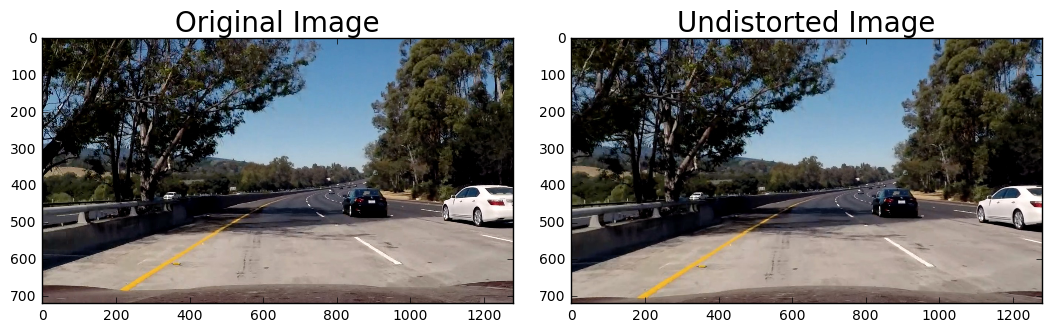

In [25]:
camera_calibration_pickle = pickle.load( open("camera_cal_pickle.p", "rb") )
calibration_matrix = camera_calibration_pickle["mtx"]
distortion_params = camera_calibration_pickle["dist"]

def undistort(image):
    return cv2.undistort(img, calibration_matrix, distortion_params, None, calibration_matrix)

# Read in test image and undistort it.
test_name = 'test_images/test5.jpg'
img = mpimg.imread(test_name)
dst = undistort(img)

# Save output image to disk for review
output_name = test_name.replace('test_images/', 'output_images/undistorted_')
mpimg.imsave(output_name, dst)

# Visualize the before and after images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)